In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

#https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74
#Importiert Daten
path = 'RKI_COVID19_2020_12_11.csv'
data = pd.read_csv(path)

data['Meldedatum']= pd.to_datetime(data['Meldedatum'])
data['Refdatum']= pd.to_datetime(data['Refdatum'])

date=pd.to_datetime("2020/10/16")
date=pd.to_datetime(data["Datenstand"][0],format="%d.%m.%Y, %M:%H Uhr")

tage=30*8

data_wup=data.loc[data['Landkreis']=='SK Wuppertal']
data_aac=data.loc[data['Landkreis']=='StadtRegion Aachen']
data_met=data.loc[data['Landkreis']=='LK Mettmann']
data_nrw=data.loc[data['Bundesland']=='Nordrhein-Westfalen']
data_han=data.loc[data['Landkreis']=='Region Hannover']

data_rem=data.loc[data['Landkreis']=='SK Remscheid']
data_sol=data.loc[data['Landkreis']=='SK Solingen']


data_list=[data_wup,data,data_aac,data_nrw,data_met,data_han]
uni_list=[data_wup,data_rem,data_sol]
uni_name_list=["Wuppertal","Remscheid","Solingen"]

name_list=["Wuppertal","Deutschland","StadtRegion Aachen","Nordrhein-Westfalen","Landkreis Mettmann","Region Hannover"]
def datum(df,date,tage,melde=True):
    #returnd Fälle von Datum(inkl) bis Datum-Tage(inkl)
    #bsp: datum(df=data_wup,date="2020/9/25",tage=2)
    end_date=pd.to_datetime(date)-pd.DateOffset(days=1)
    start_date=end_date-pd.DateOffset(days=tage)
    if melde:
        mask = (df['Meldedatum'] > start_date) & (df['Meldedatum'] <  end_date) | (df['Meldedatum'] == end_date)
    else:
        mask = (df['Refdatum'] > start_date) & (df['Refdatum'] <  end_date) | (df['Refdatum'] == end_date)
    
    return df.loc[mask]


In [42]:
daten_am_=data.loc[data['Meldedatum']==pd.to_datetime("2020/12/10")]
daten_am_['NeuerTodesfall'].value_counts()

-9    5144
 1      20
Name: NeuerTodesfall, dtype: int64

In [3]:
def draw(title="",save=""):
    plt.gcf().set_size_inches(16, 9)
    plt.gca().get_ylim()[1]
    plt.ylim(0,plt.gca().get_ylim()[1])
    plt.grid(b=True, which='major', linewidth=1)
    plt.grid(b=True, which='minor', linewidth=0.2)
    plt.minorticks_on()
    plt.title(title)
    plt.legend()
    if save != "":
        plt.savefig(f"{save}.pdf",dpi=300,transparent=False)
    plt.show()

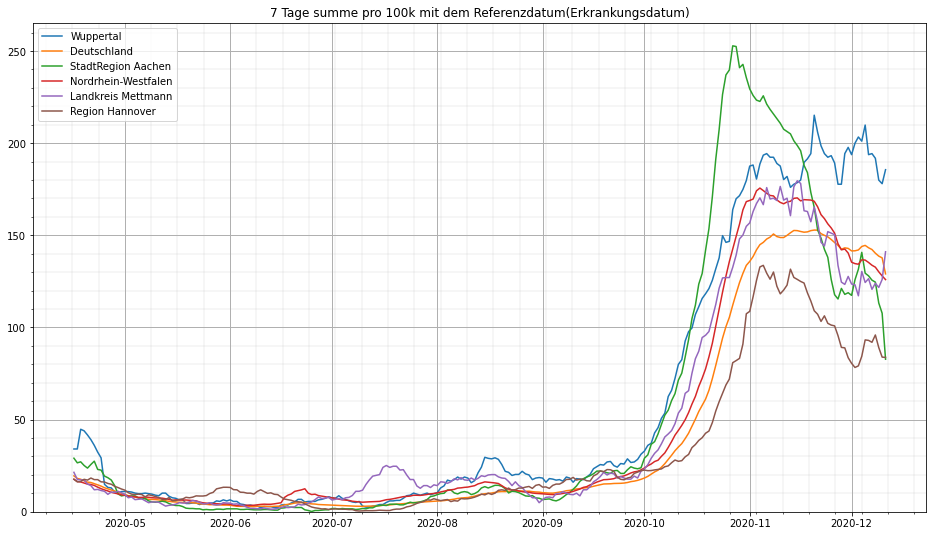

In [4]:
def interpret(data,start_date,days,days_avg,melde=True):
    #Gibt die summe an faelle wieder im zeitramen von days_avg ab dem start_date bis days in vergangenheit
    faelle=[]
    faelle_datum=[]
    for i in range(days):
        date=start_date-pd.DateOffset(days=i)
        df=datum(data,date,tage=days_avg,melde=melde)
        summe=df['AnzahlFall'].sum(axis = 0, skipna = True)
        faelle.append(summe)
        faelle_datum.append(date)
    return pd.Series(faelle,index=faelle_datum)
     
einwohner=[355100,83020000,557026,17930000,485570,1157115]
einwohner_uni=[355100,111338,159245]


data_list_faelle_ref=[interpret(df,date,tage,7,melde=False) for df in data_list]
data_list_faelle_ref_100k=[s*(100000/e)for (s,e) in zip(data_list_faelle_ref,einwohner)]


for (s,name) in zip(data_list_faelle_ref_100k,name_list):
    plt.plot(s,label=name)

draw(title="7 Tage summe pro 100k mit dem Referenzdatum(Erkrankungsdatum)",save="orte_ref")


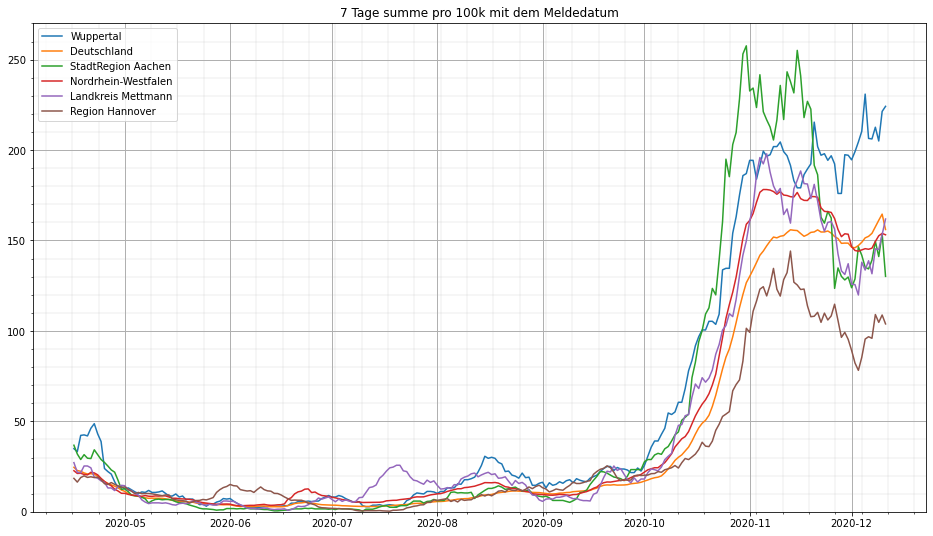

In [5]:
data_list_faelle_mel=[interpret(df,date,tage,7,melde=True) for df in data_list]
data_list_faelle_mel_100k=[s*(100000/e)for (s,e) in zip(data_list_faelle_mel,einwohner)]


for (s,name) in zip(data_list_faelle_mel_100k,name_list):
    plt.plot(s,label=name)

draw(title="7 Tage summe pro 100k mit dem Meldedatum",save="orte_melde")


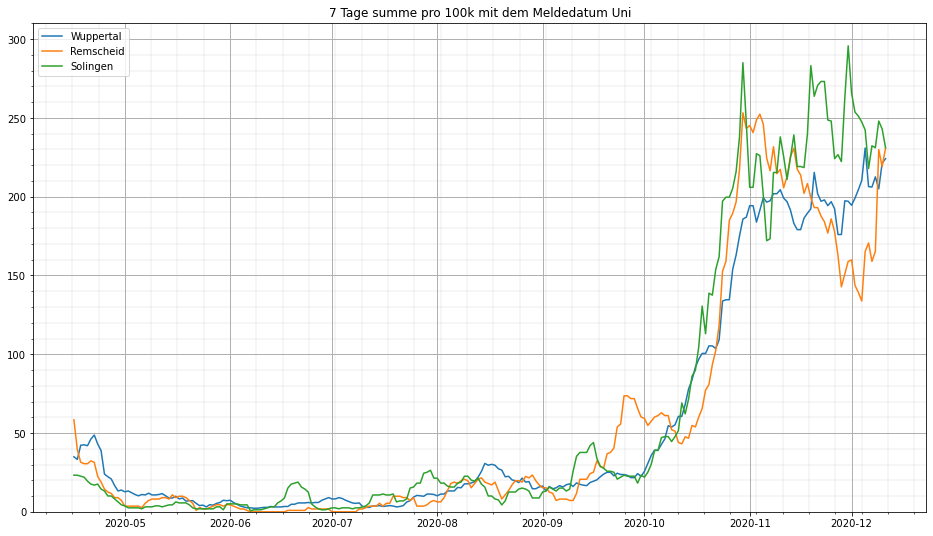

In [6]:
data_list_faelle_mel_uni=[interpret(df,date,tage,7,melde=True) for df in uni_list]
data_list_faelle_mel_100k_uni=[s*(100000/e)for (s,e) in zip(data_list_faelle_mel_uni,einwohner_uni)]


for (s,name) in zip(data_list_faelle_mel_100k_uni,uni_name_list):
    plt.plot(s,label=name)

draw(title="7 Tage summe pro 100k mit dem Meldedatum Uni",save="orte_melde_uni")


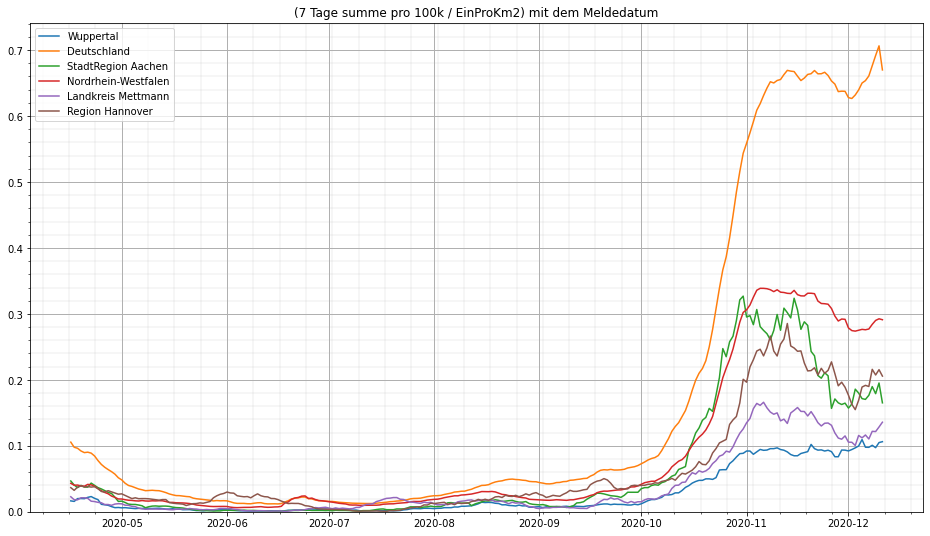

In [7]:
EinProKm2=[2109,233,788,526,1192,505]

data_list_faelle_mel_100k_EinProKm2=[s/e for (s,e) in zip(data_list_faelle_mel_100k,EinProKm2)]

for (s,name) in zip(data_list_faelle_mel_100k_EinProKm2,name_list):
    plt.plot(s,label=name)

draw(title="(7 Tage summe pro 100k / EinProKm2) mit dem Meldedatum")


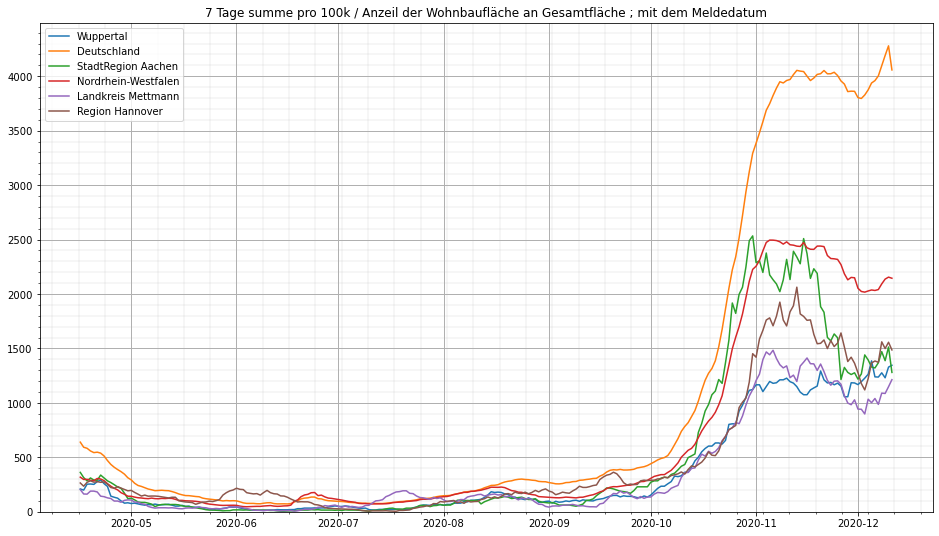

In [8]:
flaeche_ha=[16839,35758154,70691,3411231,40722,229713]
flaeche_km2=flaeche_ha*100

wohnbauflaeche_ha=[2805,1375149,7187,243576,5432,16051]
wohnbauflaeche_km2=wohnbauflaeche_ha*100

ratio_wohn_ges=[w/f for (w,f) in zip(wohnbauflaeche_km2,flaeche_km2)]
data_list_faelle_mel_100k_ratio=[s/e for (s,e) in zip(data_list_faelle_mel_100k,ratio_wohn_ges)]

for (s,name) in zip(data_list_faelle_mel_100k_ratio,name_list):
    plt.plot(s,label=name)

draw(title="7 Tage summe pro 100k / Anzeil der Wohnbaufläche an Gesamtfläche ; mit dem Meldedatum"
    ,save="orte_ratio")


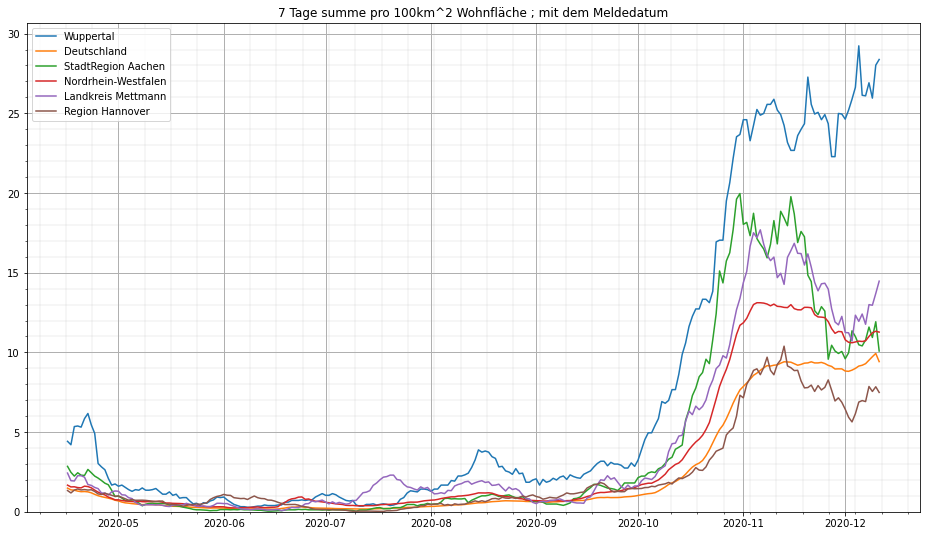

In [9]:
data_list_faelle_mel_100k_100km2_wohn=[s*(100/e)for (s,e) in zip(data_list_faelle_mel,wohnbauflaeche_km2)]

for (s,name) in zip(data_list_faelle_mel_100k_100km2_wohn,name_list):
    plt.plot(s,label=name)

draw(title="7 Tage summe pro 100km^2 Wohnfläche ; mit dem Meldedatum"
    ,save="orte_wohn")

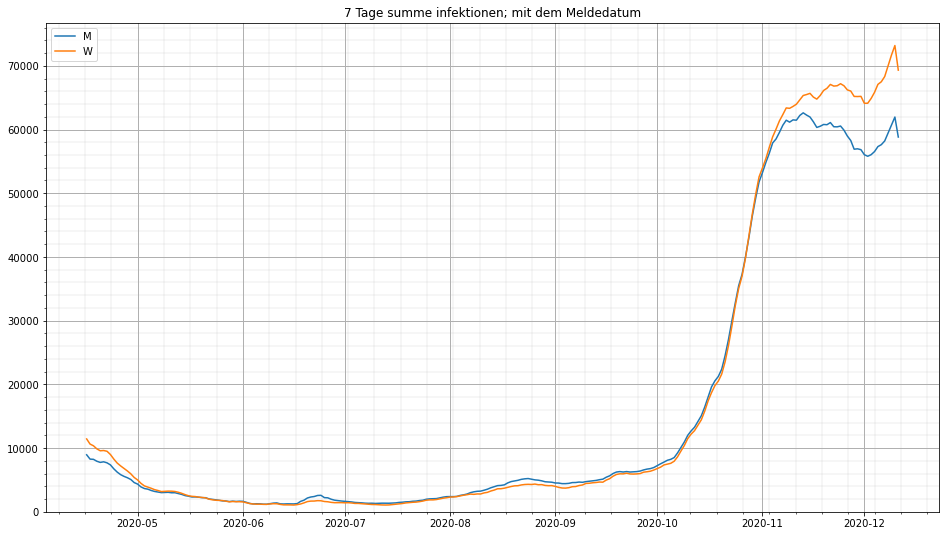

In [10]:
data_m=data.loc[data['Geschlecht']=='M']
faelle_m=interpret(data_m,date,tage,7)

data_w=data.loc[data['Geschlecht']=='W']
faelle_w=interpret(data_w,date,tage,7)

plt.plot(faelle_m,label="M")
plt.plot(faelle_w,label="W")

draw(title="7 Tage summe infektionen; mit dem Meldedatum"
    ,save="m_w")

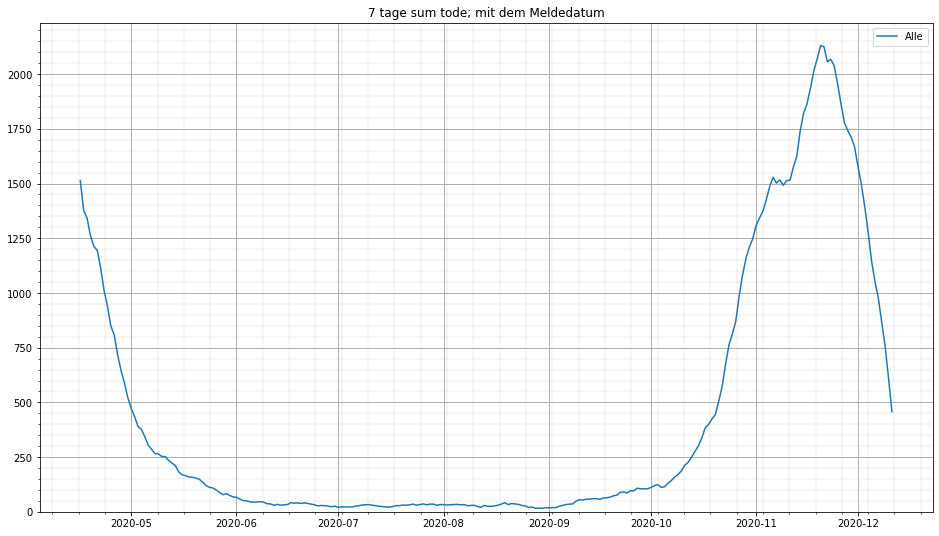

In [11]:
def interpret_death(data,start_date,days,days_avg):
    tode=[]
    tode_datum=[]
    for i in range(days):
        date=start_date-pd.DateOffset(days=i)
        df=datum(data,date,tage=days_avg)
        summe=df['AnzahlTodesfall'].sum(axis = 0, skipna = True)
        tode.append(summe)
        tode_datum.append(date)
    return pd.Series(tode,index=tode_datum)
tode=interpret_death(data,date,tage,7)
# tode_w=interpret_death(data_w,date,tage,7)
# tode_m=interpret_death(data_m,date,tage,7)

#plt.plot(tode_m,label="M")
#plt.plot(tode_w,label="W")


plt.plot(tode,label="Alle")
draw(title="7 tage sum tode; mit dem Meldedatum"
    ,save="tode")

In [12]:
datum(data,date,tage=1)#['AnzahlTodesfall'].sum(axis = 0, skipna = True)

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
20,21,1,Schleswig-Holstein,SK Kiel,A60-A79,M,1,0,2020-12-10,1002,"11.12.2020, 00:00 Uhr",1,-9,2020-12-10,-9,0,0,Nicht übermittelt
113,114,1,Schleswig-Holstein,SK Kiel,A60-A79,W,1,0,2020-12-10,1002,"11.12.2020, 00:00 Uhr",1,-9,2020-12-10,-9,0,0,Nicht übermittelt
172,173,1,Schleswig-Holstein,SK Kiel,A80+,W,1,0,2020-12-10,1002,"11.12.2020, 00:00 Uhr",1,-9,2020-12-10,-9,0,0,Nicht übermittelt
173,174,1,Schleswig-Holstein,SK Kiel,unbekannt,M,1,0,2020-12-10,1002,"11.12.2020, 00:00 Uhr",1,-9,2020-12-10,-9,0,0,Nicht übermittelt
260,261,1,Schleswig-Holstein,SK Lübeck,A05-A14,M,1,0,2020-12-10,1003,"11.12.2020, 00:00 Uhr",1,-9,2020-12-02,-9,0,1,Nicht übermittelt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687689,687690,16,Thüringen,LK Altenburger Land,A60-A79,M,7,0,2020-12-10,16077,"11.12.2020, 00:00 Uhr",1,-9,2020-12-10,-9,0,0,Nicht übermittelt
687790,687791,16,Thüringen,LK Altenburger Land,A60-A79,W,4,0,2020-12-10,16077,"11.12.2020, 00:00 Uhr",1,-9,2020-12-10,-9,0,0,Nicht übermittelt
687836,687837,16,Thüringen,LK Altenburger Land,A80+,M,2,0,2020-12-10,16077,"11.12.2020, 00:00 Uhr",1,-9,2020-12-10,-9,0,0,Nicht übermittelt
687907,687908,16,Thüringen,LK Altenburger Land,A80+,W,4,0,2020-12-10,16077,"11.12.2020, 00:00 Uhr",1,-9,2020-12-07,-9,0,1,Nicht übermittelt


In [13]:
data_wup['AnzahlTodesfall'].sum(axis = 0, skipna = True)

153

In [14]:
Altersgruppen=["A00-A04","A05-A14","A15-A34","A35-A59","A60-A79","A80+"]

path = 'altersverteilung.csv'
alt_ver = pd.read_csv(path,header=None,thousands=".")
#alt_ver[1]=pd.to_numeric(alt_ver[1])
alt_grp=[alt_ver.iloc[0:5,1].sum(),alt_ver.iloc[5:15,1].sum(),alt_ver.iloc[15:35,1].sum(),alt_ver.iloc[35:60,1].sum(),alt_ver.iloc[60:80,1].sum(),alt_ver.iloc[80:,1].sum()]
alt_grp=pd.Series(alt_grp,index=Altersgruppen)

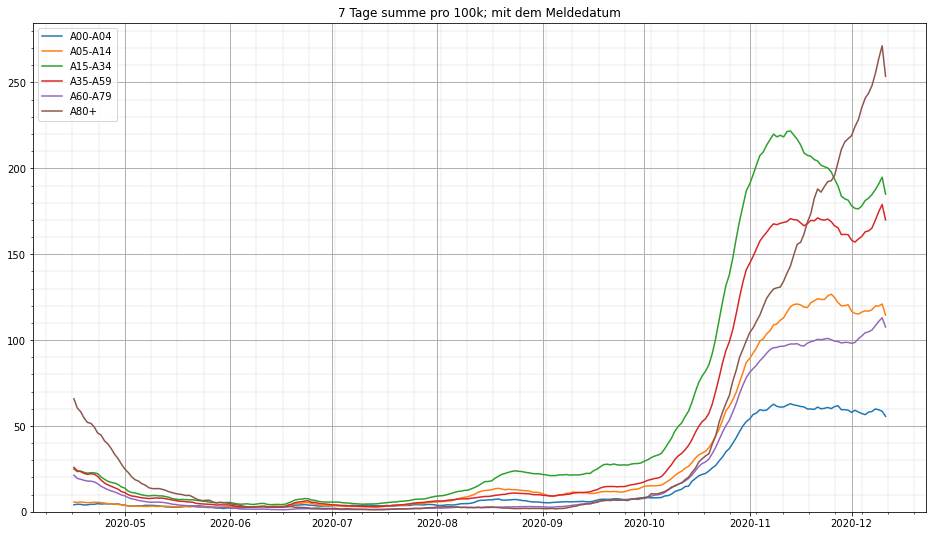

In [15]:
data_alt=[]
for gruppe in Altersgruppen:
    data_alt.append(data.loc[data["Altersgruppe"]==gruppe])
data_alt=pd.Series(data_alt,index=Altersgruppen)

data_alt_faelle=[]
for df in data_alt:
    data_alt_faelle.append(interpret(df,date,tage,7))
data_alt_faelle=pd.Series(data_alt_faelle,index=Altersgruppen)

data_alt_faelle_100k=[]
for index, value in data_alt_faelle.items():
    value=value.astype(float)
    y=(100000.0/float(alt_grp[index]))
    x=value.astype(float)*y 
    data_alt_faelle_100k.append(x)
    
data_alt_faelle_100k=pd.Series(data_alt_faelle_100k,index=Altersgruppen)
    
for index, value in data_alt_faelle_100k.items():
    plt.plot(value,label=index)

draw(title="7 Tage summe pro 100k; mit dem Meldedatum"
    ,save="alter")

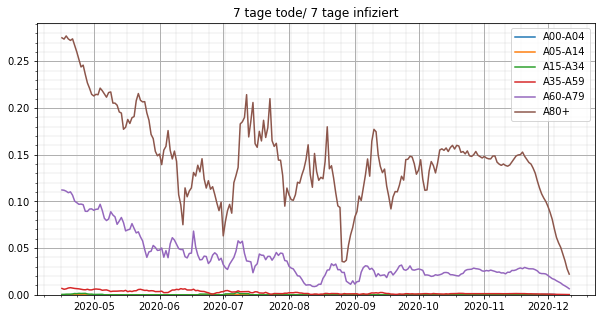

In [16]:
data_alt_tode=[]
for df in data_alt:
    data_alt_tode.append(interpret_death(df,date,tage,7))
data_alt_tode=pd.Series(data_alt_tode,index=Altersgruppen)

data_alt_tode_anteil=[]
for index, value in data_alt_tode.items():
    x=value.divide(data_alt_faelle[index],fill_value=0)
    data_alt_tode_anteil.append(x)
    
data_alt_tode_anteil=pd.Series(data_alt_tode_anteil,index=Altersgruppen)

for index, value in data_alt_tode_anteil.items():
    plt.plot(value,label=index)
    
plt.gcf().set_size_inches(10, 5)
plt.gca().get_ylim()[1]
plt.ylim(0,plt.gca().get_ylim()[1])
plt.grid(b=True, which='major',  linewidth=1)
plt.grid(b=True, which='minor',  linewidth=0.2)
plt.minorticks_on()
plt.title("7 tage tode/ 7 tage infiziert")
plt.legend()
plt.savefig(f"alter_tode.pdf",dpi=300,transparent=False)
plt.show()

In [17]:
test = pd.read_csv('testdaten.txt', sep=" ", header=None,thousands=".")
test.columns = ["KW", "Anzahl Testungen", "Positiv getestet", "Positivenquote in %","Anzahl übermittelnde Labore"]
test['Positivenquote in %'] = test["Positivenquote in %"].str.replace(',', '').astype(float)/100
test["KW"]= test["KW"].apply(lambda x: pd.to_datetime(f"2020-{x}-1",format="%Y-%W-%w"))
test

def scale(df,test):
    for i in range(len(test.index)):
        start_date=test["KW"][i]
        end_date=test["KW"][i]+pd.DateOffset(days=7)
    mask = (df['Refdatum'] > start_date) & (df['Refdatum'] <  end_date) | (df['Refdatum'] == end_date)

In [18]:
scale(data,test)